# Prepare environment

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely.geometry import box, Polygon

from tqdm import tqdm

In [2]:
import sys
sys.path.append("..//..")
import config

import warnings
warnings.filterwarnings('ignore')

# Data reading

## Amazon borders

In [3]:
# legal amazon limits
am_bounds = gpd.read_file(config.AMAZON_FRONTIER_DATA)

## DETER warnings

In [4]:
# deter deforestation alerts
deter = gpd.read_file(config.DETER_DATA)
print("Shape:", deter.shape)
deter.head(1)

Shape: (344983, 14)


,FID,CLASSNAME,QUADRANT,PATH_ROW,VIEW_DATE,SENSOR,SATELLITE,AREAUCKM,UC,AREAMUNKM,MUNICIPALI,GEOCODIBGE,UF,geometry
0,100002_hist,CICATRIZ_DE_QUEIMADA,None,170105,2018-01-11,AWFI,CBERS-4,0.0,None,0.459839,Monte Alegre,1504802,PA,"POLYGON ((-54.04199 -1.90637, -54.04199 -1.906..."


In [5]:
deter["CLASSNAME"].value_counts()

CLASSNAME
DESMATAMENTO_CR         229756
CICATRIZ_DE_QUEIMADA     61129
DEGRADACAO               30769
DESMATAMENTO_VEG          8221
MINERACAO                 6731
CS_DESORDENADO            4949
CS_GEOMETRICO             3425
DEGRDACAO                    2
CORTE_SELETIVO               1
Name: count, dtype: int64

In [6]:
# filtrar CLASSNAME
deter = deter[deter["CLASSNAME"].isin([
    "DESMATAMENTO_CR", "DESMATAMENTO_VEG", "MINERACAO"
])].copy()

### Date format

In [7]:
# datetime data formatting
deter["date"] = pd.to_datetime(deter["VIEW_DATE"])

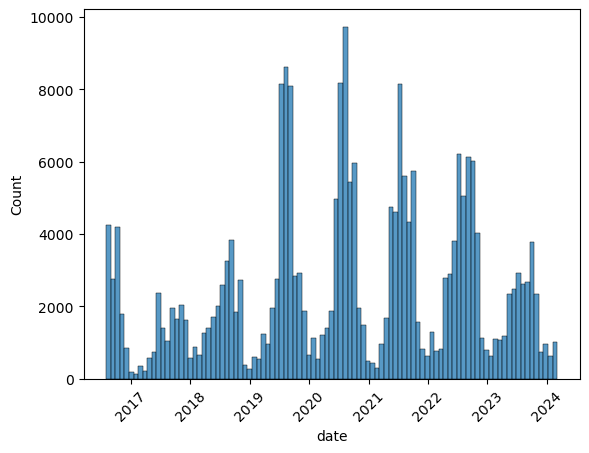

In [8]:
fig, ax = plt.subplots()
sns.histplot(deter, x="date", binwidth=28)
plt.xticks(rotation=45)
plt.show()

## Prodes

In [9]:
init_defor = gpd.read_file(config.INITIAL_DEFORESTATION)
print("Shape:", init_defor.shape)
init_defor.head(1)

Shape: (206350, 16)


,fid,state,path_row,main_class,class_name,def_cloud,julian_day,image_date,year,area_km,scene_id,source,satellite,sensor,uuid,geometry
0,1,RO,23268,DESMATAMENTO,d2007,0.0,0,None,2010.0,0.168487,0,Amazonia,Landsat,OLI,99f0fcd9-956a-412a-be60-5fc40c32f189,"POLYGON ((-63.32990 -11.89132, -63.32963 -11.8..."


In [10]:
init_defor["main_class"].value_counts()

main_class
DESMATAMENTO    206350
Name: count, dtype: int64

In [11]:
init_defor["year"].value_counts()

year
2007.0    206330
2009.0         5
2010.0         3
2013.0         3
2011.0         3
2016.0         2
2008.0         2
2018.0         1
2019.0         1
Name: count, dtype: int64

In [12]:
init_defor = init_defor[init_defor["year"] <= 2018].copy()

In [13]:
init_defor["area_km"].describe()

count    2.063490e+05
mean     3.481317e+00
std      1.300468e+02
min      3.960044e-09
25%      2.552718e-02
50%      7.459131e-02
75%      2.108483e-01
max      1.701348e+04
Name: area_km, dtype: float64

<Axes: >

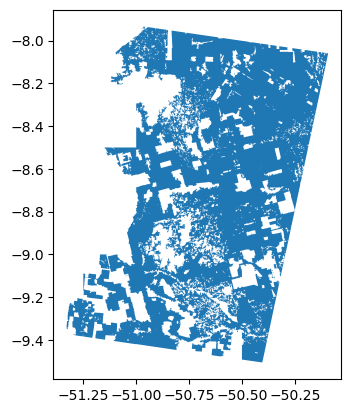

In [14]:
# big areas?
init_defor[init_defor["area_km"] > 10000].head(1).plot()

In [15]:
(init_defor["area_km"] >= 100).sum()

525

## Model grid

In [16]:
%%time

grid = gpd.read_file(config.TR_FRAMES)

CPU times: total: 15min 33s
Wall time: 15min 33s


In [17]:
grid.head(2)

,frame_id,x,y,in_borders,geometry
0,0,0,0,0,"POLYGON ((-73.99097 -18.04177, -73.99097 -18.0..."
1,1,0,1,0,"POLYGON ((-73.99097 -18.03176, -73.99097 -18.0..."


In [18]:
# compute bounds for each grid square
grid_bounds = grid.bounds

## Frames index

In [19]:
frames_idx = pd.read_csv(config.TR_FRAMES_IDX, index_col=0)

# Create time grid with accumalated deforestation area

In [20]:
def compute_in_grid(areas, grid):
    # compute intersection of deforestation areas with grid
    intersections = gpd.overlay(
        grid[["frame_id", "geometry"]], 
        areas[["geometry"]].reset_index(),
        how="intersection", 
        keep_geom_type=False
    ).dissolve(["frame_id"]).reset_index()
    intersections["area"] = intersections.geometry.area / (config.BOX_SIDE**2)
    
    return intersections[["frame_id", "area"]]

In [21]:
%%time

# initial deforestation grid (with prodes initial)
prodes_grid_list = []

# first add small prodes areas
prodes_grid_list.append(compute_in_grid(init_defor[init_defor["area_km"] < 200], grid[grid["in_borders"] == 1]))

CPU times: total: 2min 50s
Wall time: 2min 50s


In [22]:
# now add the big areas
big_areas_init = init_defor[init_defor["area_km"] >= 200].sort_values("area_km", ascending=True)
for ind, row in tqdm(big_areas_init.iterrows(), total=len(big_areas_init)):
    # get big area in geodataframe format
    big_area_df = gpd.GeoDataFrame([row])
    # filter grid around
    min_x, min_y, max_x, max_y = big_area_df.total_bounds
    subgrid = grid[
        (grid_bounds["minx"] < max_x) &
        (grid_bounds["maxx"] > min_x) &
        (grid_bounds["miny"] < max_y) &
        (grid_bounds["maxy"] > min_y)
    ]
    prodes_grid_list.append(
        compute_in_grid(big_area_df, subgrid[subgrid["in_borders"] == 1])
    )

100%|██████████████████████████████████████████████████████████████████████████████| 308/308 [1:16:28<00:00, 14.90s/it]


In [23]:
init_grid = pd.concat(prodes_grid_list, axis=0).groupby("frame_id")["area"].sum().reset_index()

In [24]:
init_grid["date"] = "2007-12-31"

In [25]:
# temporal incremental list
past_defor = [init_grid]

In [26]:
# for each time step, add areas based on deter warnings
last_dt = "2000-01-01"
for idt, dt in tqdm(enumerate(config.TIME_STEPS), total=len(config.TIME_STEPS)):
    dt_deter = deter[(deter["date"] >= last_dt) & (deter["date"] < dt)]
    # compute additional deforestation
    dt_add = compute_in_grid(dt_deter, grid[grid["in_borders"] == 1])
    # group by frame id, add date and append in final list
    dt_grid = dt_add.groupby("frame_id")["area"].sum().reset_index()
    dt_grid["date"] = dt
    past_defor.append(dt_grid)
    # update date
    last_dt = dt

100%|████████████████████████████████████████████████████████████████████████████████| 258/258 [50:28<00:00, 11.74s/it]


In [27]:
past_defor_df = pd.concat(past_defor, axis=0)
past_defor_df.shape

(1485979, 3)

In [37]:
past_defor_df["date"] = pd.to_datetime(past_defor_df["date"])

In [38]:
%%time

past_defor_df.to_csv(config.TR_PAST_DEFOR)

CPU times: total: 4.62 s
Wall time: 4.63 s
